# 1. Import Required Libraries

In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json
from itertools import product
import optuna
import time

warnings.filterwarnings("ignore")

# 2. Initialize Global Variables and Helper Functions

In [84]:
SEQUENCE_LENGTH = 12
MODEL_DIR = 'clove_models'

#create model directory if it does not exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created model directory: {MODEL_DIR}")

# Initialize preprocessors
scaler_features = StandardScaler()
scaler_target = StandardScaler()
label_encoders = {}

# 3. Data Loading and Preparation Functions

In [85]:
def load_and_prepare_data(data_path):
    """Load and prepare the clove price dataset"""
    # Load data
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Handle missing values in Regional_Price
    missing_before = df['Regional_Price'].isna().sum()
    missing_after = df['Regional_Price'].isna().sum()
    print(f"Missing Regional_Price values: {missing_before} -> {missing_after}")

    # Encode categorical variables
    for col in ['Grade', 'Region']:
        if col not in label_encoders: 
            label_encoders[col] = LabelEncoder()
        df[f'{col}_encoded'] = label_encoders[col].fit_transform(df[col])

    # Create additional time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Create lag features for key variables
    df = df.sort_values(['Grade', 'Region', 'Month'])
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Exchange_Rate', 'Inflation_Rate']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    rolling_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Exchange_Rate', 'Inflation_Rate']
    for col in rolling_columns:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    print(f"Unique grades: {df['Grade'].unique()}")
    print(f"Unique regions: {df['Region'].unique()}")

    return df

# 4. Load Data

In [86]:
DATA_PATH = 'C:/VERGER/Spice_Price_Prediction/Clove/Datasets/Clove_Dataset.csv'
df = load_and_prepare_data(DATA_PATH)
print("\nData loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head()
df.info()

Loading data from C:/VERGER/Spice_Price_Prediction/Clove/Datasets/Clove_Dataset.csv...
Initial data shape: (1470, 17)
Columns: ['Month', 'Grade', 'Region', 'Regional_Price', 'National_Price', 'Seasonal_Impact', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Local_Production_Volume', 'Local_Export_Volume', 'Global_Production_Volume', 'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price']
Missing Regional_Price values: 0 -> 0
Creating lag and rolling features...
Final data shape after feature engineering: (1470, 85)
Unique grades: ['Clove' 'Stem']
Unique regions: ['Badulla' 'Colombo' 'Galle' 'Gampaha' 'Hambantota' 'Kalutara' 'Kandy'
 'Kegalle' 'Kurunegala' 'Matale' 'Matara' 'Monaragala' 'Nuwaraeliya'
 'Ratnapura']

Data loaded successfully!
Shape: (1470, 85)

First few rows:
<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 5 to 1465
Data columns (total 85 columns):
 #   Column                              Non-Null Count  Dtyp

# 5. Price Distribution by Grade

<Figure size 1400x800 with 0 Axes>

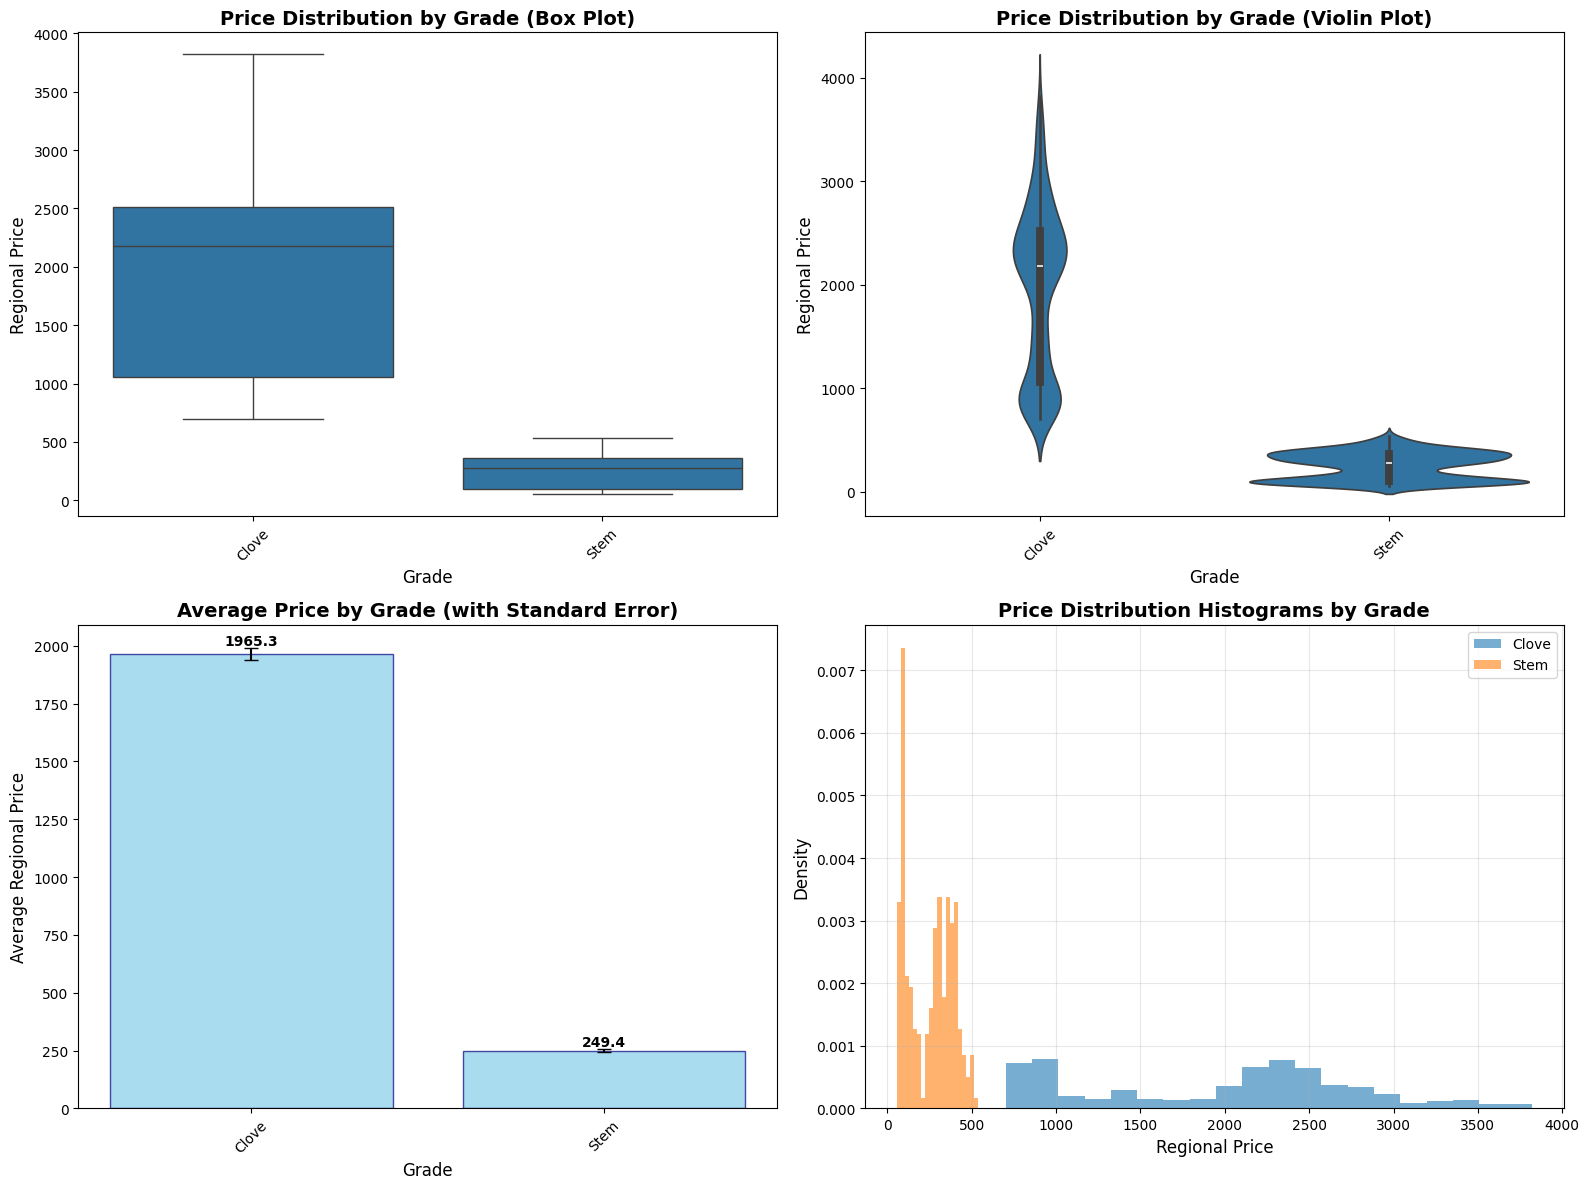


Price Distribution Summary by Grade:
       count     mean     std    min      25%      50%      75%     max
Grade                                                                  
Clove  980.0  1965.32  801.88  700.0  1058.83  2181.62  2514.50  3821.0
Stem   490.0   249.43  133.09   55.0   100.81   279.00   365.75   537.5


In [87]:
def plot_price_distribution_by_grade(df):
    """Plot price distribution by grade"""
    plt.figure(figsize=(14, 8))
    
    # Remove rows with missing Regional_Price
    df_clean = df.dropna(subset=['Regional_Price'])
    
    # Create subplots for different visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Box plot of prices by grade
    sns.boxplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax1)
    ax1.set_title('Price Distribution by Grade (Box Plot)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Grade', fontsize=12)
    ax1.set_ylabel('Regional Price', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Violin plot for detailed distribution
    sns.violinplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax2)
    ax2.set_title('Price Distribution by Grade (Violin Plot)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Grade', fontsize=12)
    ax2.set_ylabel('Regional Price', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Mean prices by grade with error bars
    grade_stats = df_clean.groupby('Grade')['Regional_Price'].agg(['mean', 'std', 'count']).reset_index()
    grade_stats['se'] = grade_stats['std'] / np.sqrt(grade_stats['count'])
    
    ax3.bar(grade_stats['Grade'], grade_stats['mean'], 
            yerr=grade_stats['se'], capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_title('Average Price by Grade (with Standard Error)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Grade', fontsize=12)
    ax3.set_ylabel('Average Regional Price', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, (grade, mean_price) in enumerate(zip(grade_stats['Grade'], grade_stats['mean'])):
        ax3.text(i, mean_price + grade_stats['se'].iloc[i], f'{mean_price:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 4. Histogram of all prices colored by grade
    for grade in df_clean['Grade'].unique():
        grade_data = df_clean[df_clean['Grade'] == grade]['Regional_Price']
        ax4.hist(grade_data, alpha=0.6, label=grade, bins=20, density=True)
    
    ax4.set_title('Price Distribution Histograms by Grade', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Regional Price', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPrice Distribution Summary by Grade:")
    print("=" * 50)
    summary_stats = df_clean.groupby('Grade')['Regional_Price'].describe()
    print(summary_stats.round(2))

plot_price_distribution_by_grade(df)

# 6. Feature Correlation Matrix

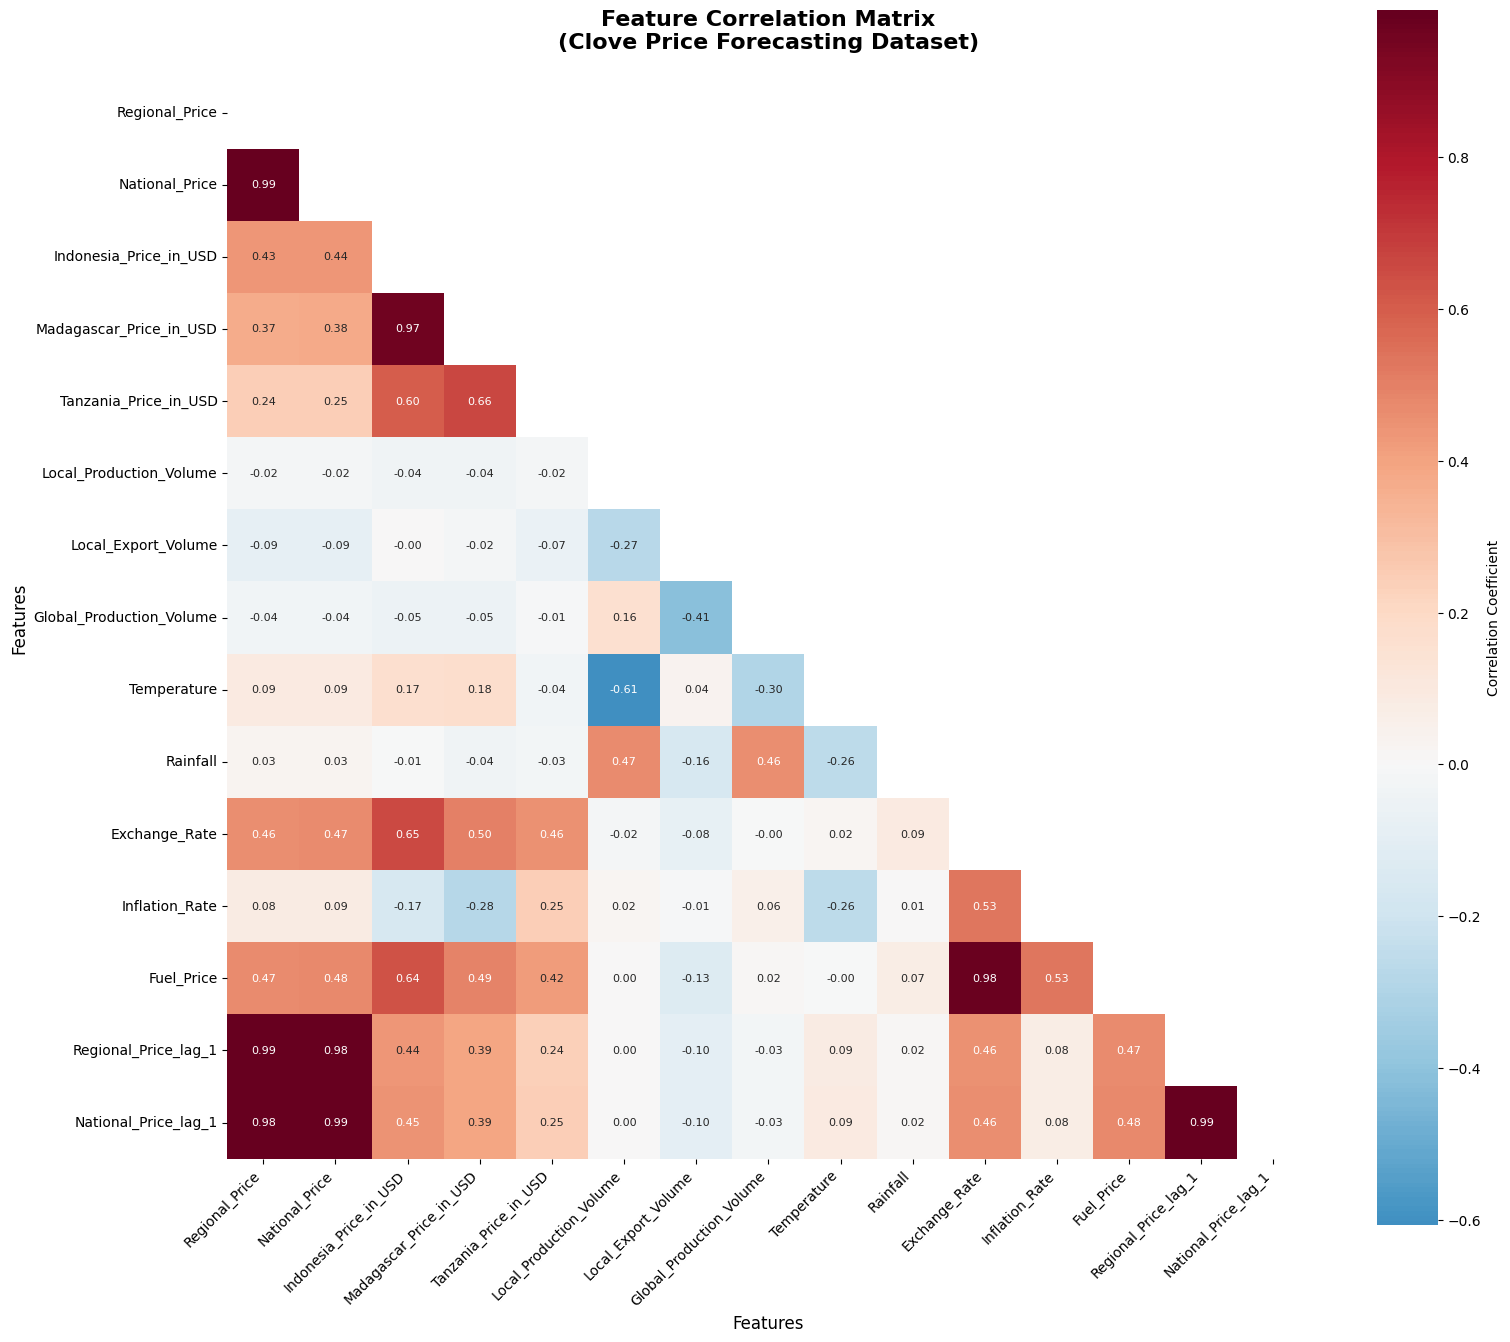


Highly Correlated Feature Pairs (|correlation| > 0.7):
National_Price ↔ National_Price_lag_1: 0.995
Regional_Price ↔ Regional_Price_lag_1: 0.991
Regional_Price ↔ National_Price: 0.989
Regional_Price_lag_1 ↔ National_Price_lag_1: 0.989
Regional_Price ↔ National_Price_lag_1: 0.984
National_Price ↔ Regional_Price_lag_1: 0.984
Exchange_Rate ↔ Fuel_Price: 0.980
Indonesia_Price_in_USD ↔ Madagascar_Price_in_USD: 0.969


In [88]:
def plot_feature_correlation_matrix(df):
    """Plot feature correlation matrix"""
    # Select numeric features for correlation analysis
    numeric_features = [
    'Regional_Price', 
    'National_Price', 
    'Indonesia_Price_in_USD', 
    'Madagascar_Price_in_USD', 
    'Tanzania_Price_in_USD',
    'Local_Production_Volume',
    'Local_Export_Volume',
    'Global_Production_Volume',
    'Temperature', 
    'Rainfall', 
    'Exchange_Rate', 
    'Inflation_Rate',
    'Fuel_Price',
    'Regional_Price_lag_1',
    'National_Price_lag_1'
]
    
    # Filter to only include columns that exist in the dataframe
    available_features = [col for col in numeric_features if col in df.columns]
    
    # Calculate correlation matrix
    df_numeric = df[available_features].select_dtypes(include=[np.number])
    correlation_matrix = df_numeric.corr()
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})
    
    plt.title('Feature Correlation Matrix\n(Clove Price Forecasting Dataset)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print highly correlated feature pairs
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
    print("=" * 60)
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_val
                ))
    
    if high_corr_pairs:
        for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feature1} ↔ {feature2}: {corr:.3f}")
    else:
        print("No feature pairs with |correlation| > 0.7 found.")

plot_feature_correlation_matrix(df)

# 7. Sequence Preparation Function for LSTM

In [89]:
def prepare_sequences(df, sequence_length=12, target_col='Regional_Price'):
    """Create sequences for LSTM training"""
    feature_cols = [
        'Grade_encoded', 'Region_encoded',
        'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
        'Local_Export_Volume', 'Global_Production_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
        'Year', 'Month_num', 'Quarter','Indonesia_Price_in_USD','Madagascar_Price_in_USD','Tanzania_Price_in_USD'
    ]

    # Add lag and rolling features
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col]
    feature_cols.extend(lag_cols)

    # Instead of dropping all NaNs, fill them
    df_clean = df.copy()
    df_clean = df_clean.fillna(method='bfill').fillna(method='ffill')

    X_sequences, y_sequences, metadata = [], [], []

    for grade in df_clean['Grade'].unique():
        for region in df_clean['Region'].unique():
            subset = df_clean[(df_clean['Grade'] == grade) & (df_clean['Region'] == region)].sort_values('Month')

            if len(subset) < sequence_length + 1:
                continue

            for i in range(len(subset) - sequence_length):
                X_seq = subset.iloc[i:i + sequence_length][feature_cols].values
                y_seq = subset.iloc[i + sequence_length][target_col]

                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
                metadata.append({
                    'grade': grade,
                    'region': region,
                    'date': subset.iloc[i + sequence_length]['Month']
                })

    print("Total sequences created:", len(X_sequences))
    return np.array(X_sequences), np.array(y_sequences), metadata

# 8. LSTM Model Building with Hyperparameter Tuning

In [90]:
def build_lstm_model_tunable(units1=128, units2=64, dropout1=0.2, dropout2=0.2, 
                            dense_units=32, optimizer='adam', learning_rate=0.001, 
                            layer_type='LSTM', use_batch_norm=False, input_shape=None):
    """Build tunable LSTM model with various hyperparameters"""
    model = Sequential()
    
    # Choose layer type
    if layer_type == 'LSTM':
        model.add(LSTM(units1, return_sequences=True, input_shape=input_shape))
    elif layer_type == 'GRU':
        model.add(GRU(units1, return_sequences=True, input_shape=input_shape))
    else:  # SimpleRNN
        model.add(SimpleRNN(units1, return_sequences=True, input_shape=input_shape))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    
    model.add(Dropout(dropout1))
    
    # Second RNN layer
    if layer_type == 'LSTM':
        model.add(LSTM(units2, return_sequences=False))
    elif layer_type == 'GRU':
        model.add(GRU(units2, return_sequences=False))
    else:  # SimpleRNN
        model.add(SimpleRNN(units2, return_sequences=False))
    
    if use_batch_norm:
        model.add(BatchNormalization())
        
    model.add(Dropout(dropout2))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    
    # Configure optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:  # SGD
        opt = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

# 9. Define Tuner Class

In [91]:
class HyperparameterTuner:
    """Hyperparameter tuning class using multiple strategies"""
    
    def __init__(self, X_train, y_train, X_val, y_val, input_shape):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.input_shape = input_shape
        self.best_params = None
        self.best_score = float('inf')
        self.tuning_results = []
    
    def grid_search_tuning(self, param_grid=None, max_trials=20):
        """Grid search hyperparameter tuning"""
        print("\n🔍 Starting Grid Search Hyperparameter Tuning...")
        print("=" * 60)
        
        if param_grid is None:
            param_grid = {
                'units1': [64, 128, 256, 512, 1024],
                'units2': [32, 64, 128, 256, 512],
                'dropout1': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dropout2': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dense_units': [16, 32, 64, 128, 256],
                'learning_rate': [0.001, 0.0005, 0.002, 0.005, 0.01],
                'layer_type': ['LSTM', 'GRU'],
                'use_batch_norm': [True, False]
            }
        
        # Generate all combinations and sample randomly if too many
        param_combinations = list(product(*param_grid.values()))
        if len(param_combinations) > max_trials:
            param_combinations = np.random.choice(
                param_combinations, size=max_trials, replace=False
            )
        
        print(f"Testing {len(param_combinations)} parameter combinations...")
        
        best_val_loss = float('inf')
        best_params = None
        
        for i, params in enumerate(param_combinations[:max_trials]):
            param_dict = dict(zip(param_grid.keys(), params))
            
            try:
                print(f"\nTrial {i+1}/{min(len(param_combinations), max_trials)}: {param_dict}")
                
                # Build and train model
                model = build_lstm_model_tunable(**param_dict, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=30,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': param_dict.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = param_dict.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Grid Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def optuna_tuning(self, n_trials=50):
        """Optuna-based hyperparameter tuning"""
        print("\n🎯 Starting Optuna Hyperparameter Tuning...")
        print("=" * 60)
        
        def objective(trial):
            # Define hyperparameter search space
            params = {
                'units1': trial.suggest_categorical('units1', [64, 128, 256, 512]),
                'units2': trial.suggest_categorical('units2', [32, 64, 128, 256]),
                'dropout1': trial.suggest_float('dropout1', 0.1, 0.5, step=0.1),
                'dropout2': trial.suggest_float('dropout2', 0.1, 0.5, step=0.1),
                'dense_units': trial.suggest_categorical('dense_units', [16, 32, 64, 128]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
                'layer_type': trial.suggest_categorical('layer_type', ['LSTM', 'GRU']),
                'use_batch_norm': trial.suggest_categorical('use_batch_norm', [True, False]),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
            }
            
            try:
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
                return val_loss
                
            except Exception as e:
                print(f"Trial failed: {e}")
                return float('inf')
        
        # Create study and optimize
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        self.best_params = study.best_params
        self.best_score = study.best_value
        
        print(f"\n🎉 Optuna Tuning Complete!")
        print(f"Best validation loss: {study.best_value:.6f}")
        print(f"Best parameters: {study.best_params}")
        
        # Plot optimization history
        self.plot_optuna_results(study)
        
        return study.best_params, study.best_value
    
    def plot_optuna_results(self, study):
        """Plot Optuna optimization results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot optimization history
        trials = study.trials
        values = [t.value for t in trials if t.value is not None]
        ax1.plot(values, marker='o', alpha=0.7)
        ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot parameter importance
        if len(study.trials) > 10:
            try:
                importance = optuna.importance.get_param_importances(study)
                params = list(importance.keys())
                importances = list(importance.values())
                
                ax2.barh(params, importances)
                ax2.set_title('Parameter Importance', fontsize=14, fontweight='bold')
                ax2.set_xlabel('Importance')
                ax2.grid(True, alpha=0.3)
            except:
                ax2.text(0.5, 0.5, 'Parameter importance\nnot available', 
                        ha='center', va='center', transform=ax2.transAxes)
        
        # Plot best value progression
        best_values = []
        current_best = float('inf')
        for trial in study.trials:
            if trial.value is not None and trial.value < current_best:
                current_best = trial.value
            best_values.append(current_best)
        
        ax3.plot(best_values, marker='o', alpha=0.7, color='green')
        ax3.set_title('Best Value Progression', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Trial')
        ax3.set_ylabel('Best Validation Loss')
        ax3.grid(True, alpha=0.3)
        
        # Distribution of validation losses
        ax4.hist(values, bins=20, alpha=0.7, edgecolor='black')
        ax4.axvline(study.best_value, color='red', linestyle='--', 
                   label=f'Best: {study.best_value:.6f}')
        ax4.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Validation Loss')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def random_search_tuning(self, n_trials=30):
        """Random search hyperparameter tuning"""
        print("\n🎲 Starting Random Search Hyperparameter Tuning...")
        print("=" * 60)
        
        best_val_loss = float('inf')
        best_params = None
        
        for i in range(n_trials):
            # Randomly sample hyperparameters
            params = {
                'units1': np.random.choice([64, 128, 256, 512]),
                'units2': np.random.choice([32, 64, 128, 256]),
                'dropout1': np.random.uniform(0.1, 0.5),
                'dropout2': np.random.uniform(0.1, 0.5),
                'dense_units': np.random.choice([16, 32, 64, 128]),
                'learning_rate': np.random.loguniform(1e-4, 1e-2),
                'layer_type': np.random.choice(['LSTM', 'GRU']),
                'use_batch_norm': np.random.choice([True, False]),
                'optimizer': np.random.choice(['adam', 'rmsprop'])
            }
            
            try:
                print(f"\nTrial {i+1}/{n_trials}: {params}")
                
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': params.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = params.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Random Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def plot_tuning_results(self):
        """Plot hyperparameter tuning results"""
        if not self.tuning_results:
            print("No tuning results to plot.")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Extract data
        trials = [r['trial'] for r in self.tuning_results]
        val_losses = [r['val_loss'] for r in self.tuning_results]
        val_maes = [r['val_mae'] for r in self.tuning_results]
        
        # Plot validation loss progression
        ax1.plot(trials, val_losses, marker='o', alpha=0.7)
        ax1.set_title('Validation Loss by Trial', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot validation MAE progression
        ax2.plot(trials, val_maes, marker='s', alpha=0.7, color='orange')
        ax2.set_title('Validation MAE by Trial', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Trial')
        ax2.set_ylabel('Validation MAE')
        ax2.grid(True, alpha=0.3)
        
        # Histogram of validation losses
        ax3.hist(val_losses, bins=15, alpha=0.7, edgecolor='black')
        ax3.axvline(self.best_score, color='red', linestyle='--', 
                   label=f'Best: {self.best_score:.6f}')
        ax3.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Validation Loss')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Best value progression
        best_so_far = []
        current_best = float('inf')
        for loss in val_losses:
            if loss < current_best:
                current_best = loss
            best_so_far.append(current_best)
        
        ax4.plot(trials, best_so_far, marker='o', alpha=0.7, color='green')
        ax4.set_title('Best Validation Loss Progression', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Trial')
        ax4.set_ylabel('Best Validation Loss')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# 10. Perform Hyperparameter Tuning

In [92]:
def perform_hyperparameter_tuning(X_train, y_train, X_val, y_val, input_shape, 
                                 method='optuna', n_trials=30):
    """Main function to perform hyperparameter tuning"""
    print(f"\n🚀 Starting Hyperparameter Tuning using {method.upper()} method...")
    
    tuner = HyperparameterTuner(X_train, y_train, X_val, y_val, input_shape)
    
    if method == 'optuna':
        best_params, best_score = tuner.optuna_tuning(n_trials=n_trials)
    elif method == 'random':
        best_params, best_score = tuner.random_search_tuning(n_trials=n_trials)
    else:
        raise ValueError("Method must be 'optuna', 'grid', or 'random'")
    
    # Plot results
    if method in ['grid', 'random']:
        tuner.plot_tuning_results()
    
    return best_params, best_score, tuner

# 11. LSTM Model Building Function

In [93]:
def build_lstm_model(input_shape, best_params=None):
    """Build LSTM model with optional best parameters from tuning"""
    if best_params is None:
        # Default parameters
        best_params = {
            'units1': 128,
            'units2': 64,
            'dropout1': 0.2,
            'dropout2': 0.2,
            'dense_units': 32,
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'layer_type': 'LSTM',
            'use_batch_norm': False
        }
    
    return build_lstm_model_tunable(**best_params, input_shape=input_shape)

# 12. Training History Visualization Function

In [94]:
def plot_training_history(history):
    """Plot training vs validation loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training & validation MAE
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='blue')
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
    ax2.set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]
    
    print(f"\nFinal Training Metrics:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Training MAE: {final_train_mae:.4f}")
    print(f"Validation MAE: {final_val_mae:.4f}")

# 13. Model Training Function

In [95]:

def train_model(df, use_tuning=True, tuning_method='optuna', n_tuning_trials=20):
    """Train the forecasting model with optional hyperparameter tuning"""
    global scaler_features, scaler_target
    
    print("Preparing sequences...")
    X, y, metadata = prepare_sequences(df, SEQUENCE_LENGTH)

    if len(X) == 0:
        raise ValueError("No sequences could be created. Check if there's enough data.")

    print(f"Created {len(X)} sequences with shape {X.shape}")

    # Scale features and target
    print("Scaling features...")
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    X_scaled_reshaped = scaler_features.fit_transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

    y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

    # Train-validation-test split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of total
    )

    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
    print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

    input_shape = (X_train.shape[1], X_train.shape[2])
    best_params = None
    tuner = None
    
    # Hyperparameter tuning
    if use_tuning:
        print(f"\n🔧 Performing hyperparameter tuning using {tuning_method} method...")
        best_params, best_score, tuner = perform_hyperparameter_tuning(
            X_train, y_train, X_val, y_val, input_shape, 
            method=tuning_method, n_trials=n_tuning_trials
        )
        
        print(f"\n📊 Hyperparameter Tuning Results:")
        print(f"Best validation loss: {best_score:.6f}")
        print(f"Best parameters:")
        for key, value in best_params.items():
            print(f"  {key}: {value}")
    else:
        print("\nSkipping hyperparameter tuning, using default parameters...")

    # Build and train final model with best parameters
    print("\nBuilding final model with optimized parameters...")
    model = build_lstm_model(input_shape, best_params)
    
    # Print model summary
    print("\n📋 Final Model Architecture:")
    model.summary()

    print("\nTraining final model...")
    
    # Use longer training for final model
    final_epochs = 150 if use_tuning else 100
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=final_epochs,
        batch_size=32,
        verbose=1,
        callbacks=[
            EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=8, factor=0.5, verbose=1)
        ]
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    print("\nEvaluating final model on test set...")
    y_pred = model.predict(X_test)
    y_pred_unscaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    print(f"\n🎯 Final Model Performance on Test Set:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Create comprehensive results dictionary
    results = {
        'mae': mae, 
        'rmse': rmse, 
        'r2': r2,
        'best_params': best_params,
        'tuning_method': tuning_method if use_tuning else None,
        'tuning_used': use_tuning,
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1]
    }
    
    # Add tuning results if available
    if tuner and hasattr(tuner, 'tuning_results'):
        results['tuning_results'] = tuner.tuning_results
    
    return model, history, results

# 14. Train the Model

🚀 STARTING MODEL TRAINING WITH HYPERPARAMETER TUNING
Preparing sequences...


[I 2025-11-12 14:29:32,262] A new study created in memory with name: no-name-3ef24002-961c-4e0a-87d1-65fe01895863


Total sequences created: 1218
Created 1218 sequences with shape (1218, 12, 81)
Scaling features...
Training set shape: X=(730, 12, 81), y=(730,)
Validation set shape: X=(244, 12, 81), y=(244,)
Test set shape: X=(244, 12, 81), y=(244,)

🔧 Performing hyperparameter tuning using optuna method...

🚀 Starting Hyperparameter Tuning using OPTUNA method...

🎯 Starting Optuna Hyperparameter Tuning...


Best trial: 0. Best value: 0.0155902:   2%|▏         | 1/50 [01:27<1:11:46, 87.90s/it]

[I 2025-11-12 14:31:00,157] Trial 0 finished with value: 0.01559018436819315 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.004831049942100729, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 0 with value: 0.01559018436819315.


Best trial: 1. Best value: 0.0135432:   4%|▍         | 2/50 [02:01<44:36, 55.77s/it]  

[I 2025-11-12 14:31:33,432] Trial 1 finished with value: 0.013543202541768551 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.00566657220464698, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.013543202541768551.


Best trial: 1. Best value: 0.0135432:   6%|▌         | 3/50 [02:40<37:48, 48.27s/it]

[I 2025-11-12 14:32:12,785] Trial 2 finished with value: 0.015008850023150444 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.006930848306514001, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 1 with value: 0.013543202541768551.


Best trial: 1. Best value: 0.0135432:   8%|▊         | 4/50 [03:23<35:30, 46.32s/it]

[I 2025-11-12 14:32:56,111] Trial 3 finished with value: 0.02268041856586933 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.001767484603212602, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 1 with value: 0.013543202541768551.


Best trial: 1. Best value: 0.0135432:  10%|█         | 5/50 [03:50<29:20, 39.12s/it]

[I 2025-11-12 14:33:22,477] Trial 4 finished with value: 0.026730846613645554 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.5, 'dense_units': 128, 'learning_rate': 0.0003122654937389043, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 1 with value: 0.013543202541768551.


Best trial: 1. Best value: 0.0135432:  12%|█▏        | 6/50 [04:09<23:47, 32.43s/it]

[I 2025-11-12 14:33:41,918] Trial 5 finished with value: 0.026075975969433784 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.5, 'dense_units': 32, 'learning_rate': 0.00012147325409639632, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.013543202541768551.


Best trial: 6. Best value: 0.0128835:  14%|█▍        | 7/50 [04:33<21:09, 29.53s/it]

[I 2025-11-12 14:34:05,461] Trial 6 finished with value: 0.01288345642387867 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.001088057501554043, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 6 with value: 0.01288345642387867.


Best trial: 6. Best value: 0.0128835:  16%|█▌        | 8/50 [05:11<22:40, 32.39s/it]

[I 2025-11-12 14:34:43,994] Trial 7 finished with value: 0.035346172749996185 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0037188805208046563, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 6 with value: 0.01288345642387867.


Best trial: 6. Best value: 0.0128835:  18%|█▊        | 9/50 [05:41<21:37, 31.65s/it]

[I 2025-11-12 14:35:14,004] Trial 8 finished with value: 0.013389823958277702 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.002706193003208236, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 6 with value: 0.01288345642387867.


Best trial: 6. Best value: 0.0128835:  20%|██        | 10/50 [06:26<23:45, 35.64s/it]

[I 2025-11-12 14:35:58,590] Trial 9 finished with value: 0.014168954454362392 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dense_units': 16, 'learning_rate': 0.0003560101355123217, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 6 with value: 0.01288345642387867.


Best trial: 10. Best value: 0.0119963:  22%|██▏       | 11/50 [06:49<20:38, 31.76s/it]

[I 2025-11-12 14:36:21,522] Trial 10 finished with value: 0.011996296234428883 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0009402898977833773, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  24%|██▍       | 12/50 [07:11<18:18, 28.92s/it]

[I 2025-11-12 14:36:43,959] Trial 11 finished with value: 0.012727269902825356 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0008316398760883124, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  26%|██▌       | 13/50 [07:32<16:13, 26.32s/it]

[I 2025-11-12 14:37:04,288] Trial 12 finished with value: 0.013807299546897411 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0005422666171450623, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  28%|██▊       | 14/50 [07:53<14:49, 24.70s/it]

[I 2025-11-12 14:37:25,271] Trial 13 finished with value: 0.015091382898390293 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.4, 'dense_units': 32, 'learning_rate': 0.0008067862206704788, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  30%|███       | 15/50 [08:14<13:51, 23.75s/it]

[I 2025-11-12 14:37:46,825] Trial 14 finished with value: 0.015634097158908844 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.4, 'dense_units': 32, 'learning_rate': 0.0013997014502036428, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  32%|███▏      | 16/50 [08:35<13:00, 22.95s/it]

[I 2025-11-12 14:38:07,900] Trial 15 finished with value: 0.014215443283319473 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.00017738151934350226, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  34%|███▍      | 17/50 [08:51<11:22, 20.68s/it]

[I 2025-11-12 14:38:23,291] Trial 16 finished with value: 0.015096156857907772 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0006609411457801471, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  36%|███▌      | 18/50 [09:16<11:44, 22.01s/it]

[I 2025-11-12 14:38:48,398] Trial 17 finished with value: 0.012584979645907879 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.4, 'dense_units': 32, 'learning_rate': 0.002060863072301892, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  38%|███▊      | 19/50 [09:58<14:28, 28.02s/it]

[I 2025-11-12 14:39:30,417] Trial 18 finished with value: 0.022503351792693138 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.4, 'dense_units': 32, 'learning_rate': 0.009762083775152535, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  40%|████      | 20/50 [10:43<16:34, 33.16s/it]

[I 2025-11-12 14:40:15,566] Trial 19 finished with value: 0.02845517173409462 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.0024094886554874104, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  42%|████▏     | 21/50 [11:09<14:57, 30.95s/it]

[I 2025-11-12 14:40:41,377] Trial 20 finished with value: 0.013394946232438087 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0017107849308763312, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  44%|████▍     | 22/50 [11:34<13:42, 29.37s/it]

[I 2025-11-12 14:41:07,053] Trial 21 finished with value: 0.012170907109975815 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0010395534574255002, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  46%|████▌     | 23/50 [12:00<12:40, 28.18s/it]

[I 2025-11-12 14:41:32,456] Trial 22 finished with value: 0.012932220473885536 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.00043384034181135614, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  48%|████▊     | 24/50 [12:25<11:48, 27.26s/it]

[I 2025-11-12 14:41:57,586] Trial 23 finished with value: 0.012066051363945007 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 32, 'learning_rate': 0.0010693187822164443, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 10. Best value: 0.0119963:  50%|█████     | 25/50 [12:51<11:11, 26.85s/it]

[I 2025-11-12 14:42:23,455] Trial 24 finished with value: 0.012003254145383835 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.001223196251358724, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.011996296234428883.


Best trial: 25. Best value: 0.0108462:  52%|█████▏    | 26/50 [13:23<11:23, 28.49s/it]

[I 2025-11-12 14:42:55,795] Trial 25 finished with value: 0.010846160352230072 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0012722235295458519, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  54%|█████▍    | 27/50 [13:54<11:12, 29.25s/it]

[I 2025-11-12 14:43:26,801] Trial 26 finished with value: 0.0570998340845108 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0002596649781068694, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  56%|█████▌    | 28/50 [15:15<16:26, 44.85s/it]

[I 2025-11-12 14:44:48,044] Trial 27 finished with value: 0.012758912518620491 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0031407753249301997, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  58%|█████▊    | 29/50 [16:07<16:27, 47.00s/it]

[I 2025-11-12 14:45:40,079] Trial 28 finished with value: 0.012974596582353115 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0013585907077746091, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  60%|██████    | 30/50 [17:28<19:00, 57.03s/it]

[I 2025-11-12 14:47:00,503] Trial 29 finished with value: 0.012212448753416538 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0005582513560920968, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  62%|██████▏   | 31/50 [18:00<15:44, 49.73s/it]

[I 2025-11-12 14:47:33,199] Trial 30 finished with value: 0.01309663150459528 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.004369231150164757, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  64%|██████▍   | 32/50 [18:26<12:44, 42.47s/it]

[I 2025-11-12 14:47:58,717] Trial 31 finished with value: 0.012887673452496529 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 32, 'learning_rate': 0.0012831171159015033, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  66%|██████▌   | 33/50 [18:52<10:35, 37.40s/it]

[I 2025-11-12 14:48:24,286] Trial 32 finished with value: 0.01220287848263979 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0007231851395825772, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  68%|██████▊   | 34/50 [19:25<09:38, 36.17s/it]

[I 2025-11-12 14:48:57,580] Trial 33 finished with value: 0.010988068766891956 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0009505045136512686, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  70%|███████   | 35/50 [21:22<15:07, 60.52s/it]

[I 2025-11-12 14:50:54,912] Trial 34 finished with value: 0.022720888257026672 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.001690649192731322, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  72%|███████▏  | 36/50 [24:06<21:21, 91.55s/it]

[I 2025-11-12 14:53:38,860] Trial 35 finished with value: 0.011809490621089935 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0004986818622205491, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  74%|███████▍  | 37/50 [27:28<26:59, 124.61s/it]

[I 2025-11-12 14:57:00,607] Trial 36 finished with value: 0.011130336672067642 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.00045678709558027124, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  76%|███████▌  | 38/50 [30:38<28:49, 144.16s/it]

[I 2025-11-12 15:00:10,405] Trial 37 finished with value: 0.03585127741098404 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.00023672750392300117, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  78%|███████▊  | 39/50 [34:03<29:48, 162.62s/it]

[I 2025-11-12 15:03:36,076] Trial 38 finished with value: 0.01198218110948801 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0004425877960484897, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  80%|████████  | 40/50 [37:12<28:23, 170.40s/it]

[I 2025-11-12 15:06:44,625] Trial 39 finished with value: 0.012122413143515587 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.00011855049693496323, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  82%|████████▏ | 41/50 [39:01<22:48, 152.03s/it]

[I 2025-11-12 15:08:33,799] Trial 40 finished with value: 0.07234987616539001 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0003714453204885109, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  84%|████████▍ | 42/50 [42:41<22:59, 172.47s/it]

[I 2025-11-12 15:12:13,974] Trial 41 finished with value: 0.01127447560429573 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0004941889051155718, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  86%|████████▌ | 43/50 [46:11<21:25, 183.64s/it]

[I 2025-11-12 15:15:43,671] Trial 42 finished with value: 0.011210286058485508 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0005677389383745834, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  88%|████████▊ | 44/50 [48:17<16:38, 166.35s/it]

[I 2025-11-12 15:17:49,660] Trial 43 finished with value: 0.011143109761178493 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0006201231367060378, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  90%|█████████ | 45/50 [50:33<13:06, 157.21s/it]

[I 2025-11-12 15:20:05,560] Trial 44 finished with value: 0.012956238351762295 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0006563304337239762, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  92%|█████████▏| 46/50 [52:16<09:23, 141.00s/it]

[I 2025-11-12 15:21:48,715] Trial 45 finished with value: 0.015861021354794502 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.00029023396544124646, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  94%|█████████▍| 47/50 [54:27<06:54, 138.10s/it]

[I 2025-11-12 15:24:00,060] Trial 46 finished with value: 0.014879086054861546 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.5, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0008535575015640825, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  96%|█████████▌| 48/50 [56:59<04:44, 142.09s/it]

[I 2025-11-12 15:26:31,459] Trial 47 finished with value: 0.018796870484948158 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.00017653321170082515, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462:  98%|█████████▊| 49/50 [59:10<02:18, 138.78s/it]

[I 2025-11-12 15:28:42,510] Trial 48 finished with value: 0.014659932814538479 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0003716130407658232, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.


Best trial: 25. Best value: 0.0108462: 100%|██████████| 50/50 [1:01:04<00:00, 73.29s/it] 


[I 2025-11-12 15:30:36,804] Trial 49 finished with value: 0.013015895150601864 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0006069334123675483, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010846160352230072.

🎉 Optuna Tuning Complete!
Best validation loss: 0.010846
Best parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0012722235295458519, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}


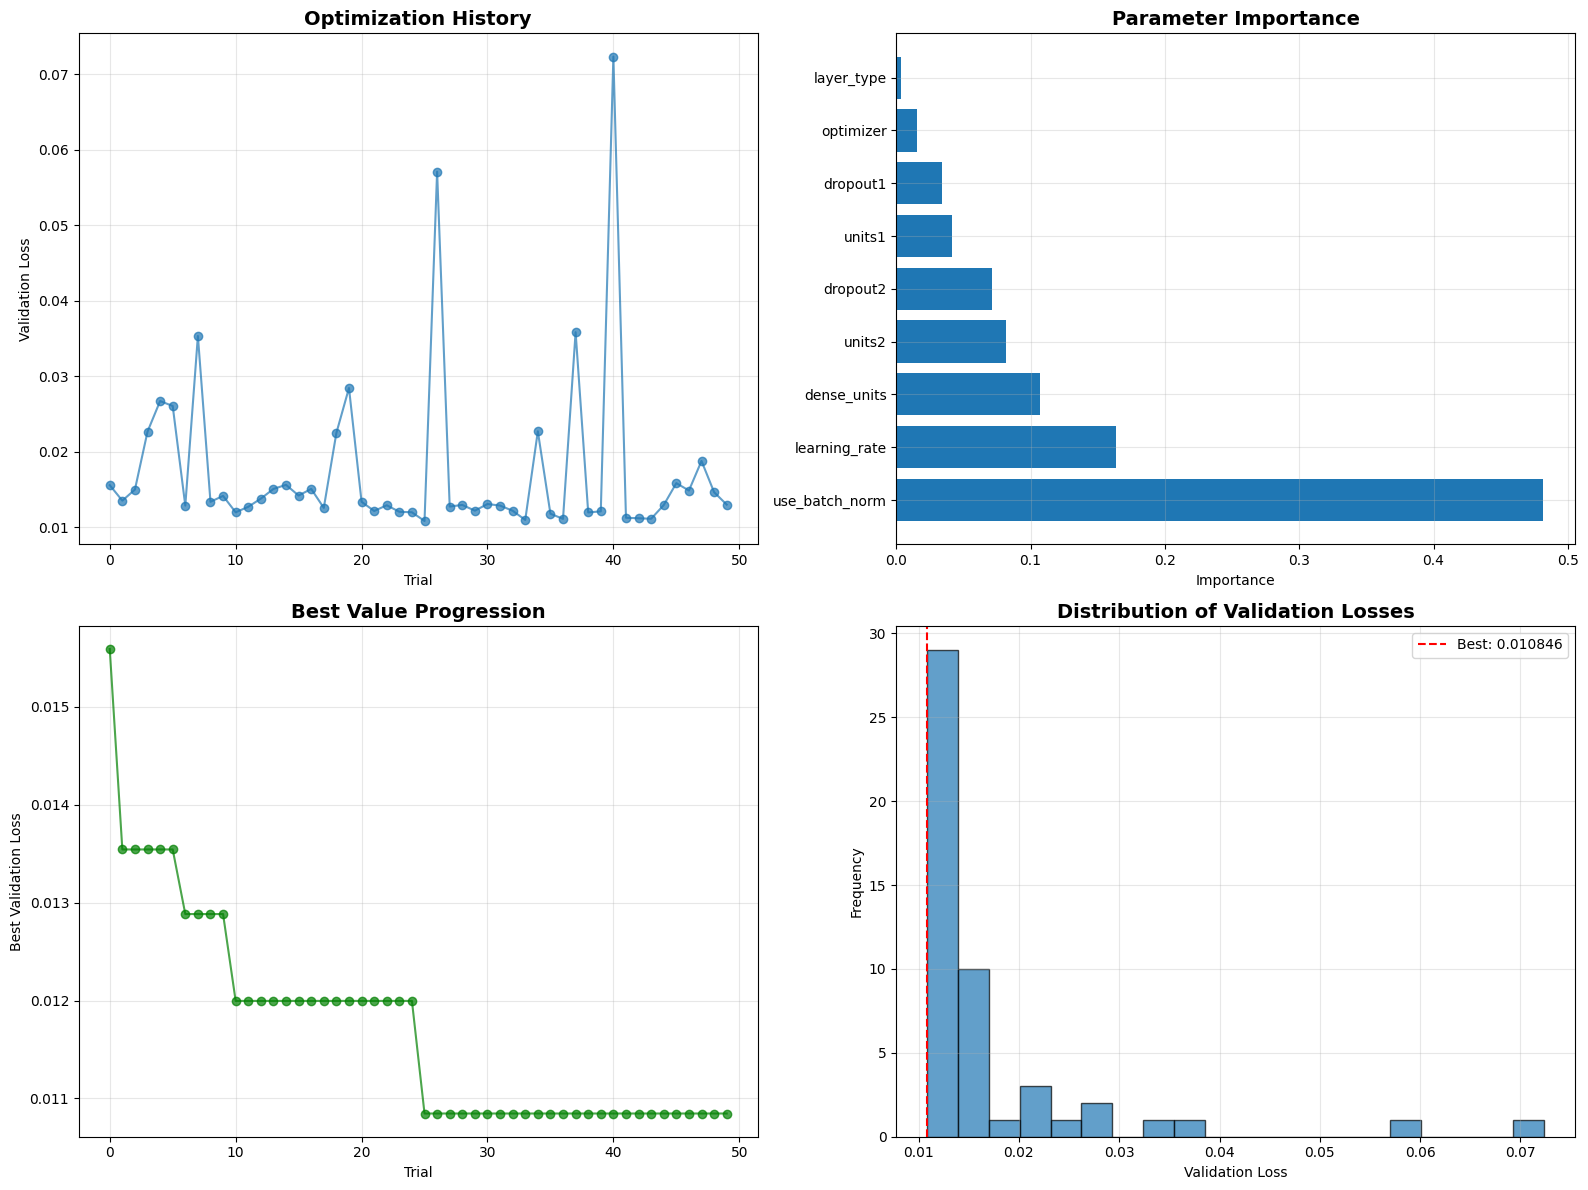


📊 Hyperparameter Tuning Results:
Best validation loss: 0.010846
Best parameters:
  units1: 64
  units2: 256
  dropout1: 0.2
  dropout2: 0.2
  dense_units: 32
  learning_rate: 0.0012722235295458519
  layer_type: LSTM
  use_batch_norm: False
  optimizer: rmsprop

Building final model with optimized parameters...

📋 Final Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,337 (1.43 MB)

 Trainable params: 374,337 (1.43 MB)

 Non-trainable params: 0 (0.00 B)


Training final model...
Epoch 1/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - loss: 0.1849 - mae: 0.2902 - val_loss: 0.0318 - val_mae: 0.1246 - learning_rate: 0.0013
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.0584 - mae: 0.1886 - val_loss: 0.0485 - val_mae: 0.1758 - learning_rate: 0.0013
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.0602 - mae: 0.1902 - val_loss: 0.0441 - val_mae: 0.1510 - learning_rate: 0.0013
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - loss: 0.0532 - mae: 0.1769 - val_loss: 0.0432 - val_mae: 0.1661 - learning_rate: 0.0013
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0427 - mae: 0.1576 - val_loss: 0.0444 - val_mae: 0.1673 - learning_rate: 0.0013
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0431 - mae: 0.1546 - val_loss: 0.0413 - val_mae: 0.1608 - learning_rate: 0.0013
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.0455 - mae: 0.1661 - val_loss: 0.0341 - val_mae: 0.15

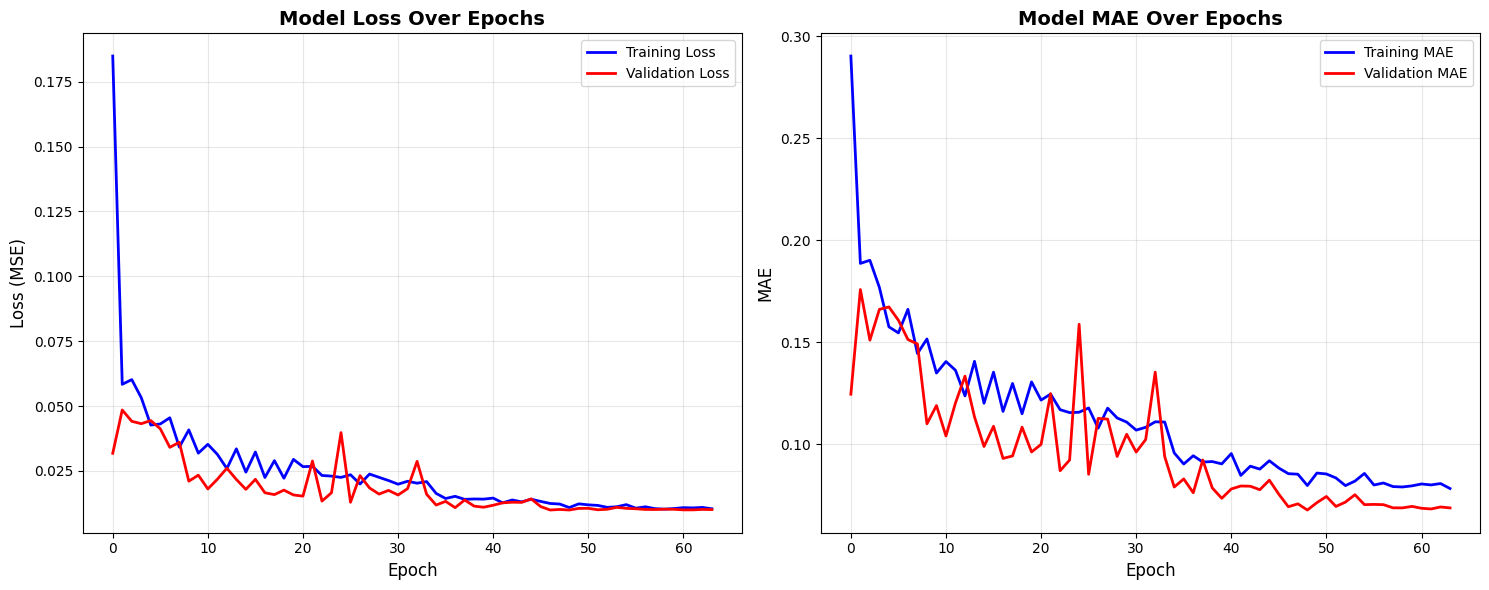


Final Training Metrics:
Training Loss: 0.0104
Validation Loss: 0.0101
Training MAE: 0.0783
Validation MAE: 0.0688

Evaluating final model on test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step

🎯 Final Model Performance on Test Set:
MAE: 89.14
RMSE: 129.27
R²: 0.9844

🎉 Model training completed!


In [96]:
# Train model with hyperparameter tuning
print("🚀 STARTING MODEL TRAINING WITH HYPERPARAMETER TUNING")
print("="*80)

# You can change these parameters:
USE_HYPERPARAMETER_TUNING = True  # Set to False to skip tuning
TUNING_METHOD = 'optuna'  # Options: 'optuna', 'grid', 'random'
N_TUNING_TRIALS = 50  # Number of trials for tuning

model, history, metrics = train_model(
    df, 
    use_tuning=USE_HYPERPARAMETER_TUNING,
    tuning_method=TUNING_METHOD,
    n_tuning_trials=N_TUNING_TRIALS
)

print("\n🎉 Model training completed!")

# 15. Save the Model

In [97]:
def save_model(model, metrics, model_dir=MODEL_DIR):
    """Save the trained model and all preprocessors"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create model-specific directory
    model_save_dir = os.path.join(model_dir, f"clove_model_{timestamp}")
    os.makedirs(model_save_dir, exist_ok=True)
    
    print(f"\n📁 Saving model to: {model_save_dir}")
    
    try:
        # 1. Save the Keras model
        model_path = os.path.join(model_save_dir, "lstm_model.keras")
        model.save(model_path)
        print(f"✅ Keras model saved: lstm_model.keras")
        
        # 2. Save scalers
        scalers_path = os.path.join(model_save_dir, "scalers.pkl")
        scalers = {
            'scaler_features': scaler_features,
            'scaler_target': scaler_target
        }
        with open(scalers_path, 'wb') as f:
            pickle.dump(scalers, f)
        print(f"✅ Scalers saved: scalers.pkl")
        
        # 3. Save label encoders
        encoders_path = os.path.join(model_save_dir, "label_encoders.pkl")
        with open(encoders_path, 'wb') as f:
            pickle.dump(label_encoders, f)
        print(f"✅ Label encoders saved: label_encoders.pkl")
        
        # 4. Save model configuration and metadata (enhanced with tuning info)
        config = {
            'sequence_length': SEQUENCE_LENGTH,
            'model_architecture': {
                'input_shape': model.input_shape,
                'layers': [str(layer.__class__.__name__) for layer in model.layers],
                'total_params': model.count_params()
            },
            'training_info': {
                'timestamp': timestamp,
                'mae': float(metrics['mae']),
                'rmse': float(metrics['rmse']),
                'r2': float(metrics['r2']),
                'tuning_used': metrics.get('tuning_used', False),
                'tuning_method': metrics.get('tuning_method', None),
                'best_params': metrics.get('best_params', None),
                'epochs_trained': metrics.get('epochs_trained', 0),
                'final_train_loss': float(metrics.get('final_train_loss', 0)),
                'final_val_loss': float(metrics.get('final_val_loss', 0))
            }
        }
        
        # Save tuning results if available
        if 'tuning_results' in metrics and metrics['tuning_results']:
            tuning_results_path = os.path.join(model_save_dir, "tuning_results.json")
            with open(tuning_results_path, 'w') as f:
                json.dump(metrics['tuning_results'], f, indent=2, default=str)
            print(f"✅ Hyperparameter tuning results saved: tuning_results.json")
        
        config_path = os.path.join(model_save_dir, "model_config.json")
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=2, default=str)
        print(f"✅ Model configuration saved: model_config.json")
        
        print(f"\n🎉 Model successfully saved to: {model_save_dir}")
        
        # Print summary of saved model
        print(f"\n📊 Saved Model Summary:")
        print(f"  • Performance: MAE={metrics['mae']:.2f}, RMSE={metrics['rmse']:.2f}, R²={metrics['r2']:.4f}")
        if metrics.get('tuning_used'):
            print(f"  • Hyperparameter tuning: {metrics['tuning_method']} method used")
            print(f"  • Best parameters found and applied")
        print(f"  • Training epochs: {metrics.get('epochs_trained', 'N/A')}")
        print(f"  • Total parameters: {model.count_params():,}")
        
        return model_save_dir
        
    except Exception as e:
        print(f"❌ Error saving model: {str(e)}")
        return None

def load_saved_model(model_path):
    """Load a previously saved model and preprocessors"""
    global scaler_features, scaler_target, label_encoders
    
    print(f"📂 Loading model from: {model_path}")
    
    try:
        # Load the Keras model
        keras_model_path = os.path.join(model_path, "lstm_model.keras")
        model = load_model(keras_model_path)
        print(f"✅ Keras model loaded")
        
        # Load scalers
        scalers_path = os.path.join(model_path, "scalers.pkl")
        with open(scalers_path, 'rb') as f:
            scalers = pickle.load(f)
        scaler_features = scalers['scaler_features']
        scaler_target = scalers['scaler_target']
        print(f"✅ Scalers loaded")
        
        # Load label encoders
        encoders_path = os.path.join(model_path, "label_encoders.pkl")
        with open(encoders_path, 'rb') as f:
            label_encoders = pickle.load(f)
        print(f"✅ Label encoders loaded")
        
        # Load configuration
        config_path = os.path.join(model_path, "model_config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        print(f"🎉 Model successfully loaded!")
        print(f"📊 Performance: MAE={config['training_info']['mae']:.2f}, "
              f"RMSE={config['training_info']['rmse']:.2f}, "
              f"R²={config['training_info']['r2']:.4f}")
        
        if config['training_info'].get('tuning_used'):
            print(f"🔧 This model was trained with {config['training_info']['tuning_method']} hyperparameter tuning")
        
        return model, config
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None
    
saved_model_path=save_model(model, metrics)
print(f"Model saved at: {saved_model_path}")


📁 Saving model to: clove_models\clove_model_20251112_153458
✅ Keras model saved: lstm_model.keras
✅ Scalers saved: scalers.pkl
✅ Label encoders saved: label_encoders.pkl
✅ Model configuration saved: model_config.json

🎉 Model successfully saved to: clove_models\clove_model_20251112_153458

📊 Saved Model Summary:
  • Performance: MAE=89.14, RMSE=129.27, R²=0.9844
  • Hyperparameter tuning: optuna method used
  • Best parameters found and applied
  • Training epochs: 64
  • Total parameters: 374,337
Model saved at: clove_models\clove_model_20251112_153458


# 16. Define Train Features Globally

In [98]:
# --- FIX: Dynamically recreate the feature list to match training order ---

# 1. Define the base features EXACTLY as they appeared in 'prepare_sequences'
base_features = [
    'Grade_encoded', 'Region_encoded',
    'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
    'Local_Export_Volume', 'Global_Production_Volume',
    'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
    'Year', 'Month_num', 'Quarter',
    'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD'
]

# 2. Extract lag and rolling features dynamically from the dataframe
# (This ensures the order matches exactly what is in your 'df')
lag_rolling_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col]

# 3. Combine them to create the master feature list
TRAIN_FEATURE_COLS = base_features + lag_rolling_cols

print(f"Feature list fixed!")
print(f"Total features: {len(TRAIN_FEATURE_COLS)}")
print(f"First 5 features: {TRAIN_FEATURE_COLS[:5]}")

Feature list fixed!
Total features: 81
First 5 features: ['Grade_encoded', 'Region_encoded', 'National_Price', 'Seasonal_Impact', 'Local_Production_Volume']


# 17. Forecasting Functions

In [115]:
def forecast_prices(model, df, grade, region, months_ahead=12):
    # --- PART 1: Setup Future Dataframe with Dynamic External Factors ---
    subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
    last_row = subset.iloc[-1]
    last_date = last_row['Month']
    history_len = len(subset)

    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                 periods=months_ahead, freq='MS')
    
    future_rows = []
    
    # Initialize current values for international prices
    curr_indonesia = last_row['Indonesia_Price_in_USD']
    curr_madagascar = last_row['Madagascar_Price_in_USD']
    curr_tanzania = last_row['Tanzania_Price_in_USD']

    print(f"Generating forecast with dynamic seasonality & market simulation...")

    for future_date in future_dates:
        row = last_row.copy()
        row['Month'] = future_date
        row['Year'] = future_date.year
        row['Month_num'] = future_date.month
        row['Quarter'] = future_date.quarter
        
        # --- FIX 1: DYNAMIC SEASONAL IMPACT ---
        # Explicitly set the seasonal flag for harvest months (Dec, Jan, Feb)
        if row['Month_num'] in [1, 2, 12]:
            row['Seasonal_Impact'] = 1
        else:
            row['Seasonal_Impact'] = 0

        # --- FIX 2: International Price Random Walk ---
        # Allow drift of up to +/- 3% per month to simulate market volatility
        curr_indonesia *= (1 + np.random.normal(0.005, 0.03)) 
        curr_madagascar *= (1 + np.random.normal(0.005, 0.03))
        curr_tanzania *= (1 + np.random.normal(0.005, 0.03))
        
        row['Indonesia_Price_in_USD'] = curr_indonesia
        row['Madagascar_Price_in_USD'] = curr_madagascar
        row['Tanzania_Price_in_USD'] = curr_tanzania

        # 3. Seasonal Factors (Cyclical Temperature/Rainfall)
        row['Temperature'] = last_row['Temperature'] + 2 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,0.5)
        row['Rainfall'] = max(0, last_row['Rainfall'] + 20 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,10))
        
        # 4. Economic Factors
        row['Exchange_Rate'] = last_row['Exchange_Rate'] * (1 + np.random.normal(0,0.01))
        row['Inflation_Rate'] = last_row['Inflation_Rate'] + np.random.normal(0,0.1)
        row['Fuel_Price'] = last_row['Fuel_Price'] * (1 + np.random.normal(0,0.02))
        
        future_rows.append(row)

    future_df = pd.DataFrame(future_rows)
    extended_df = pd.concat([subset, future_df], ignore_index=True).sort_values('Month')

    # Define which columns need dynamic updating
    cols_to_update = ['Regional_Price','National_Price','Indonesia_Price_in_USD',
                      'Tanzania_Price_in_USD','Madagascar_Price_in_USD',
                      'Temperature','Rainfall','Exchange_Rate','Inflation_Rate']

    forecasts = []

    # --- PART 2: Recursive Forecasting Loop ---
    for i in range(months_ahead):
        # The index of the month we are about to predict
        future_idx = history_len + i

        # A. Update Features Dynamicallly (Lags & Rolling Averages)
        for col in cols_to_update:
            for lag in [1,3,6,12]:
                extended_df[f'{col}_lag_{lag}'] = extended_df[col].shift(lag)
            for window in [3,6,12]:
                extended_df[f'{col}_rolling_{window}'] = extended_df[col].rolling(window).mean()

        # Fix NaNs
        extended_df = extended_df.fillna(method='ffill').fillna(method='bfill')

        # B. Extract Sequence
        current_data = extended_df.iloc[future_idx - SEQUENCE_LENGTH : future_idx]
        
        # Padding check
        if len(current_data) < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - len(current_data)
            first_valid = current_data.iloc[0:1]
            padding_data = pd.concat([first_valid]*padding_needed, ignore_index=True)
            current_data = pd.concat([padding_data, current_data], ignore_index=True)

        # Select features
        feature_cols = [c for c in TRAIN_FEATURE_COLS if c in current_data.columns]
        
        # Scale
        sequence = current_data[feature_cols].values
        sequence_flat = sequence.reshape(-1, sequence.shape[-1])
        sequence_scaled_flat = scaler_features.transform(sequence_flat)
        sequence_scaled = sequence_scaled_flat.reshape(1, SEQUENCE_LENGTH, -1)

        # C. Predict
        next_pred_scaled = model.predict(sequence_scaled, verbose=0)
        next_pred_unscaled = scaler_target.inverse_transform(next_pred_scaled)[0][0]
        forecasts.append(next_pred_unscaled)

        # D. Update DataFrame (Recursive Step)
        extended_df.at[future_idx, 'Regional_Price'] = next_pred_unscaled
        extended_df.at[future_idx, 'National_Price'] = next_pred_unscaled 

    return forecasts, future_dates

# 18. Forecast Visualization Function

In [116]:
def plot_forecast_results(df, model, grade, region, months_ahead=12):
    """Plot 2: Historical data with forecast results"""
    try:
        # Get historical data for the specific grade and region
        subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
        
        if len(subset) == 0:
            print(f"No data found for {grade} in {region}")
            return None, None
        
        # Generate forecasts
        forecasts, future_dates = forecast_prices(model, df, grade, region, months_ahead)
        
        # Create the plot
        plt.figure(figsize=(16, 8))
        
        # Plot historical data
        plt.plot(subset['Month'], subset['Regional_Price'], 
                label='Historical Prices', linewidth=2, color='blue', marker='o', markersize=4)
        
        # CREATE BRIDGE: Connect last historical point to first forecast
        last_historical_date = subset['Month'].iloc[-1]
        last_historical_price = subset['Regional_Price'].iloc[-1]
        first_forecast_date = future_dates[0]
        first_forecast_price = forecasts[0]
        
        # Plot the connecting line (bridge)
        plt.plot([last_historical_date, first_forecast_date], 
                [last_historical_price, first_forecast_price], 
                color='orange', linewidth=2, linestyle='-', alpha=0.8, 
                label='Historical-Forecast Bridge')
        
        # Plot forecasts (connected line)
        extended_forecast_dates = [last_historical_date] + list(future_dates)
        extended_forecasts = [last_historical_price] + list(forecasts)
        
        plt.plot(extended_forecast_dates, extended_forecasts, 
                label='Forecasted Prices', linewidth=2, color='red', 
                marker='s', markersize=5, linestyle='--', alpha=0.9)
        
        # Add a vertical line to separate historical and forecasted data
        plt.axvline(x=last_historical_date, color='blue', linestyle=':', alpha=0.5, linewidth=1, 
                   label='Forecast Start')
        
        # Customize the plot
        plt.title(f'Clove Price Forecast: {grade.title()} Grade in {region.title()}\n'
                 f'Historical Data vs {months_ahead}-Month Forecast', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Regional Price', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Format x-axis dates
        plt.xticks(rotation=45)
        
        # Add confidence bands (simplified approach using standard deviation)
        if len(forecasts) > 1:
            forecast_std = np.std(subset['Regional_Price'].tail(12))  # Use last 12 months std
            upper_bound = np.array(extended_forecasts[1:]) + 1.96 * forecast_std  # Exclude bridge point
            lower_bound = np.array(extended_forecasts[1:]) - 1.96 * forecast_std
            
            plt.fill_between(future_dates, lower_bound, upper_bound, 
                           alpha=0.2, color='red', label='95% Confidence Interval')
        
        plt.tight_layout()
        plt.show()
        
        # Print forecast summary
        print(f"\n{grade.title()} Grade Forecast for {region.title()}:")
        print("=" * 50)
        for i, (date, price) in enumerate(zip(future_dates, forecasts), 1):
            print(f"Month {i:2d} ({date.strftime('%Y-%m')}): LKR.{price:8.2f}")
        
        print(f"\nForecast Statistics:")
        print(f"Average Forecast Price: LKR.{np.mean(forecasts):.2f}")
        print(f"Price Range: LKR.{np.min(forecasts):.2f} - LKR.{np.max(forecasts):.2f}")
        
        # Calculate trend
        if len(forecasts) > 1:
            trend = (forecasts[-1] - forecasts[0]) / len(forecasts)
            trend_direction = "increasing" if trend > 0 else "decreasing"
            print(f"Overall Trend: {trend_direction} by LKR.{abs(trend):.2f} per month")
        
        return forecasts, future_dates
        
    except Exception as e:
        print(f"Error plotting forecast results: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# 19. Generate Forecast Visualizations

Available grades: ['Clove' 'Stem']
Available regions: ['Badulla' 'Colombo' 'Galle' 'Gampaha' 'Hambantota' 'Kalutara' 'Kandy'
 'Kegalle' 'Kurunegala' 'Matale' 'Matara' 'Monaragala' 'Nuwaraeliya'
 'Ratnapura']

📈 Generating forecast for Clove in Badulla...
Generating forecast with dynamic seasonality & market simulation...


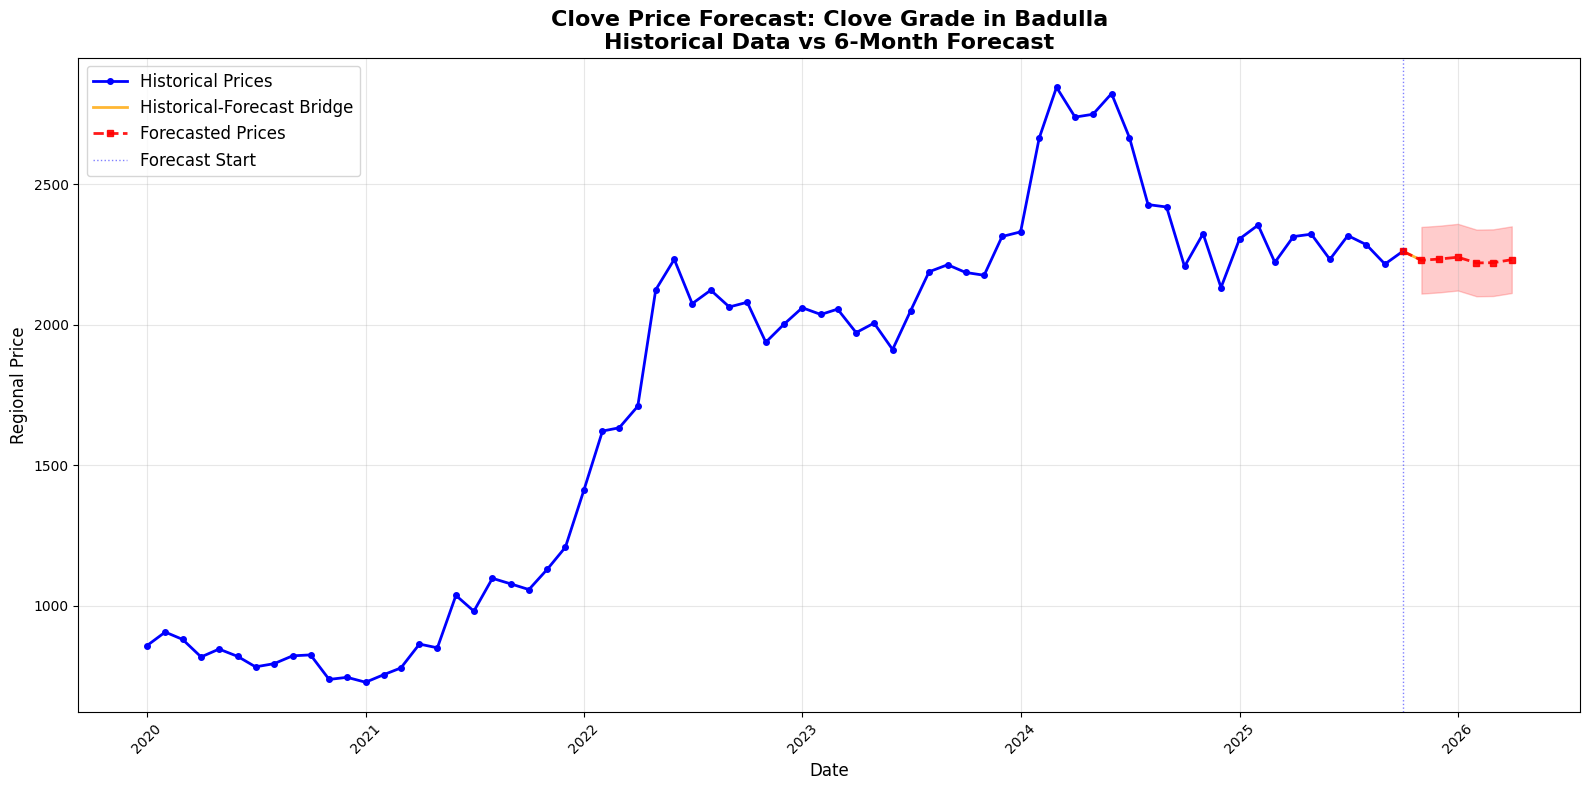


Clove Grade Forecast for Badulla:
Month  1 (2025-11): LKR. 2230.14
Month  2 (2025-12): LKR. 2234.47
Month  3 (2026-01): LKR. 2241.11
Month  4 (2026-02): LKR. 2220.69
Month  5 (2026-03): LKR. 2221.54
Month  6 (2026-04): LKR. 2232.23

Forecast Statistics:
Average Forecast Price: LKR.2230.03
Price Range: LKR.2220.69 - LKR.2241.11
Overall Trend: increasing by LKR.0.35 per month

📈 Generating forecast for Stem in Colombo...
No data found for Stem in Colombo


In [117]:
available_grades = df['Grade'].unique()
available_regions = df['Region'].unique()

print(f"Available grades: {available_grades}")
print(f"Available regions: {available_regions}")

# Generate forecast for first combination
if len(available_grades) > 0 and len(available_regions) > 0:
    grade_to_forecast = available_grades[0]
    region_to_forecast = available_regions[0]
    
    print(f"\n📈 Generating forecast for {grade_to_forecast} in {region_to_forecast}...")
    forecasts1, future_dates1 = plot_forecast_results(
        df, model, grade_to_forecast, region_to_forecast, months_ahead=6
    )

# Try another combination if available
if len(available_grades) > 1 and len(available_regions) > 1:
    grade_to_forecast2 = available_grades[1] if len(available_grades) > 1 else available_grades[0]
    region_to_forecast2 = available_regions[1] if len(available_regions) > 1 else available_regions[0]
    
    print(f"\n📈 Generating forecast for {grade_to_forecast2} in {region_to_forecast2}...")
    forecasts2, future_dates2 = plot_forecast_results(
        df, model, grade_to_forecast2, region_to_forecast2, months_ahead=6
    )

# 20. Interactive Forecast Generation


🔮 Interactive Forecast Generation

Available Grades:
1. Clove
2. Stem

Available Regions:
1. Badulla
2. Colombo
3. Galle
4. Gampaha
5. Hambantota
6. Kalutara
7. Kandy
8. Kegalle
9. Kurunegala
10. Matale
11. Matara
12. Monaragala
13. Nuwaraeliya
14. Ratnapura

📊 Generating 12-month forecast for Clove in Gampaha...
Generating forecast with dynamic seasonality & market simulation...


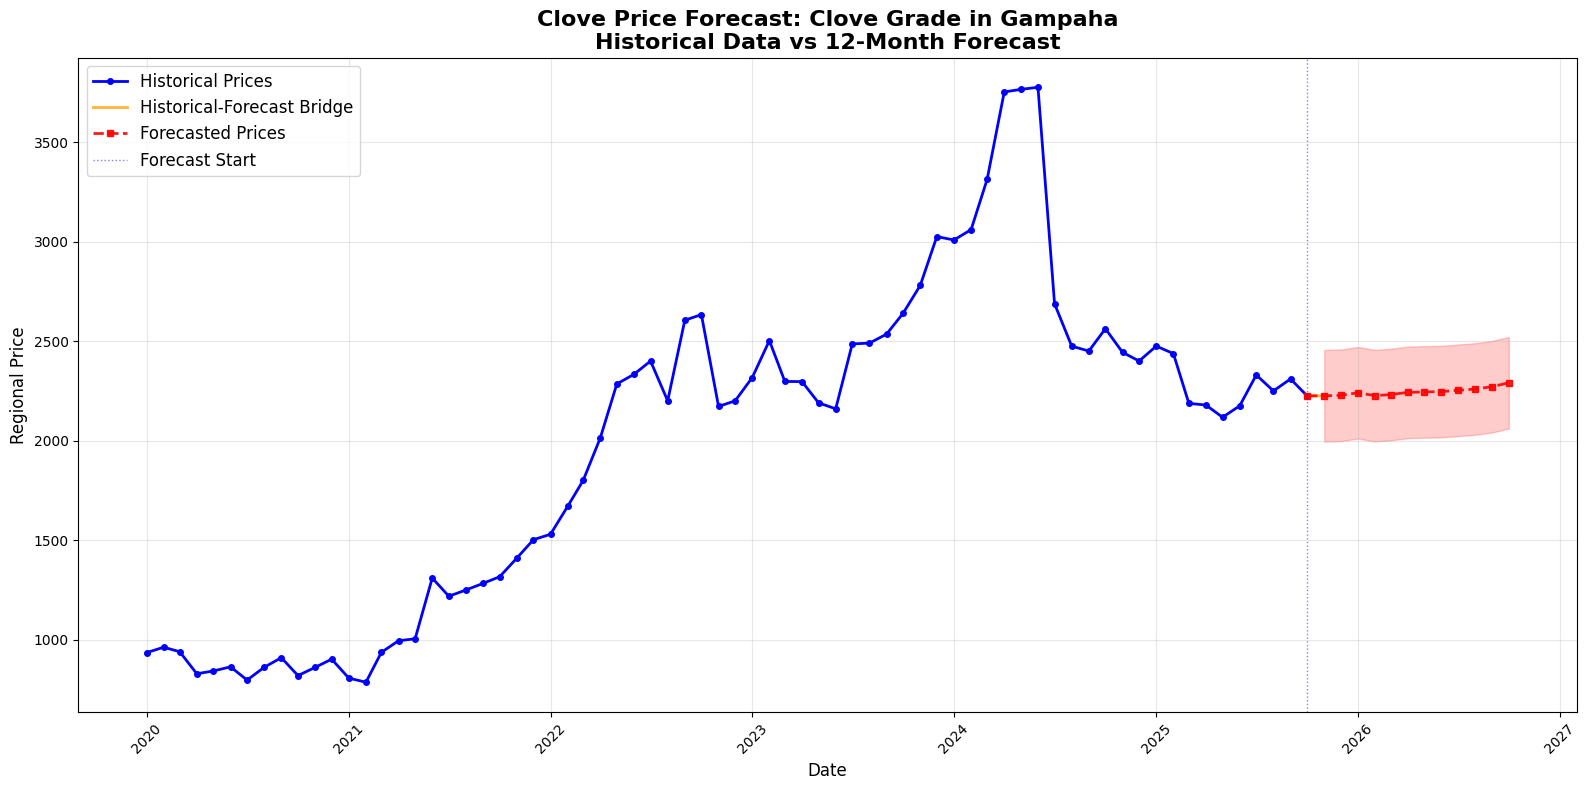


Clove Grade Forecast for Gampaha:
Month  1 (2025-11): LKR. 2225.28
Month  2 (2025-12): LKR. 2227.86
Month  3 (2026-01): LKR. 2240.62
Month  4 (2026-02): LKR. 2225.97
Month  5 (2026-03): LKR. 2231.71
Month  6 (2026-04): LKR. 2242.33
Month  7 (2026-05): LKR. 2244.89
Month  8 (2026-06): LKR. 2246.44
Month  9 (2026-07): LKR. 2252.89
Month 10 (2026-08): LKR. 2259.38
Month 11 (2026-09): LKR. 2271.23
Month 12 (2026-10): LKR. 2291.01

Forecast Statistics:
Average Forecast Price: LKR.2246.63
Price Range: LKR.2225.28 - LKR.2291.01
Overall Trend: increasing by LKR.5.48 per month


([np.float32(2225.277),
  np.float32(2227.8645),
  np.float32(2240.6204),
  np.float32(2225.967),
  np.float32(2231.7083),
  np.float32(2242.3296),
  np.float32(2244.8855),
  np.float32(2246.4368),
  np.float32(2252.8936),
  np.float32(2259.3777),
  np.float32(2271.2295),
  np.float32(2291.0088)],
 DatetimeIndex(['2025-11-01', '2025-12-01', '2026-01-01', '2026-02-01',
                '2026-03-01', '2026-04-01', '2026-05-01', '2026-06-01',
                '2026-07-01', '2026-08-01', '2026-09-01', '2026-10-01'],
               dtype='datetime64[ns]', freq='MS'))

In [118]:
def interactive_forecast():
    """Allow user to select grade and region for forecasting"""
    print("\n🔮 Interactive Forecast Generation")
    print("=" * 50)
    
    # Display available options
    print("\nAvailable Grades:")
    for i, grade in enumerate(available_grades, 1):
        print(f"{i}. {grade}")
    
    print("\nAvailable Regions:")
    for i, region in enumerate(available_regions, 1):
        print(f"{i}. {region}")
    
    # Get user input
    try:
        grade_idx = int(input("\nSelect grade number: ")) - 1
        region_idx = int(input("Select region number: ")) - 1
        months = int(input("How many months to forecast (default 6): ") or "6")
        
        if 0 <= grade_idx < len(available_grades) and 0 <= region_idx < len(available_regions):
            selected_grade = available_grades[grade_idx]
            selected_region = available_regions[region_idx]
            
            print(f"\n📊 Generating {months}-month forecast for {selected_grade} in {selected_region}...")
            forecasts, dates = plot_forecast_results(
                df, model, selected_grade, selected_region, months_ahead=months
            )
            return forecasts, dates
        else:
            print("Invalid selection. Please try again.")
            return None, None
            
    except (ValueError, IndexError) as e:
        print(f"Error: {e}. Please enter valid numbers.")
        return None, None

interactive_forecast()

Preparing test sequences...
Total sequences created: 1218
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Mean Absolute Percentage Error (MAPE): 8.99%


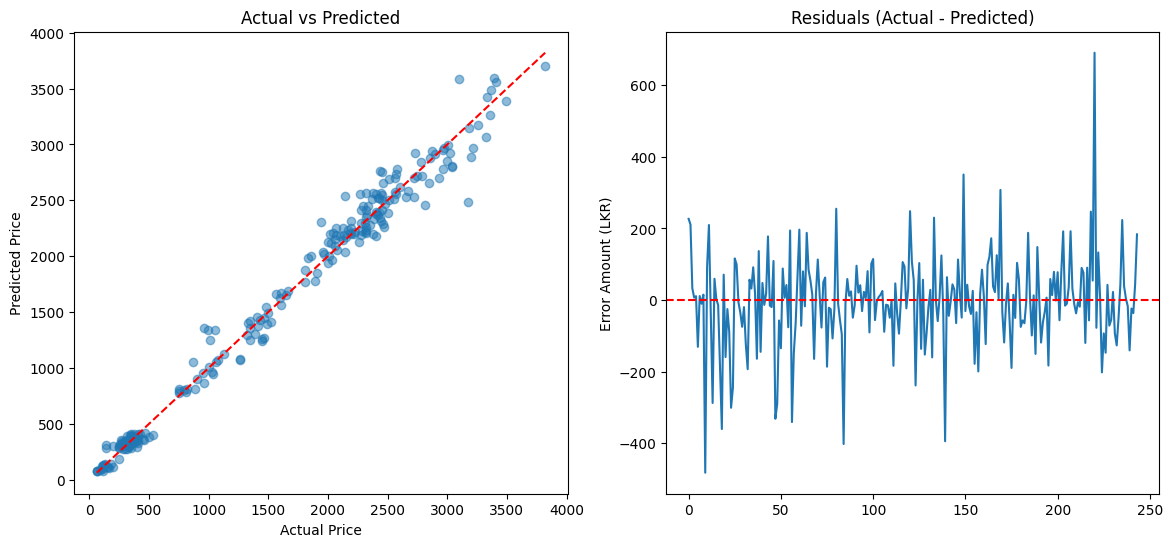

In [104]:
def analyze_errors(y_true, y_pred):
    residuals = y_true - y_pred
    
    # 1. Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    # 2. Plot Residuals
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted')
    
    plt.subplot(1, 2, 2)
    plt.plot(residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals (Actual - Predicted)')
    plt.ylabel('Error Amount (LKR)')
    plt.show()

# Generate test predictions from the trained model
print("Preparing test sequences...")
X_test_seq, y_test_seq, _ = prepare_sequences(df, SEQUENCE_LENGTH)

# Scale features and target
n_samples, n_timesteps, n_features = X_test_seq.shape
X_test_reshaped = X_test_seq.reshape(-1, n_features)
X_test_scaled = scaler_features.transform(X_test_reshaped).reshape(n_samples, n_timesteps, n_features)
y_test_scaled = scaler_target.transform(y_test_seq.reshape(-1, 1)).flatten()

# Split to get test set
_, X_test, _, y_test = train_test_split(X_test_scaled, y_test_scaled, test_size=0.2, random_state=42)

# Generate predictions
y_pred = model.predict(X_test)
y_pred_unscaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Run error analysis
analyze_errors(y_test_unscaled, y_pred_unscaled)


Generating predictions for residual analysis...
Total sequences created: 1218


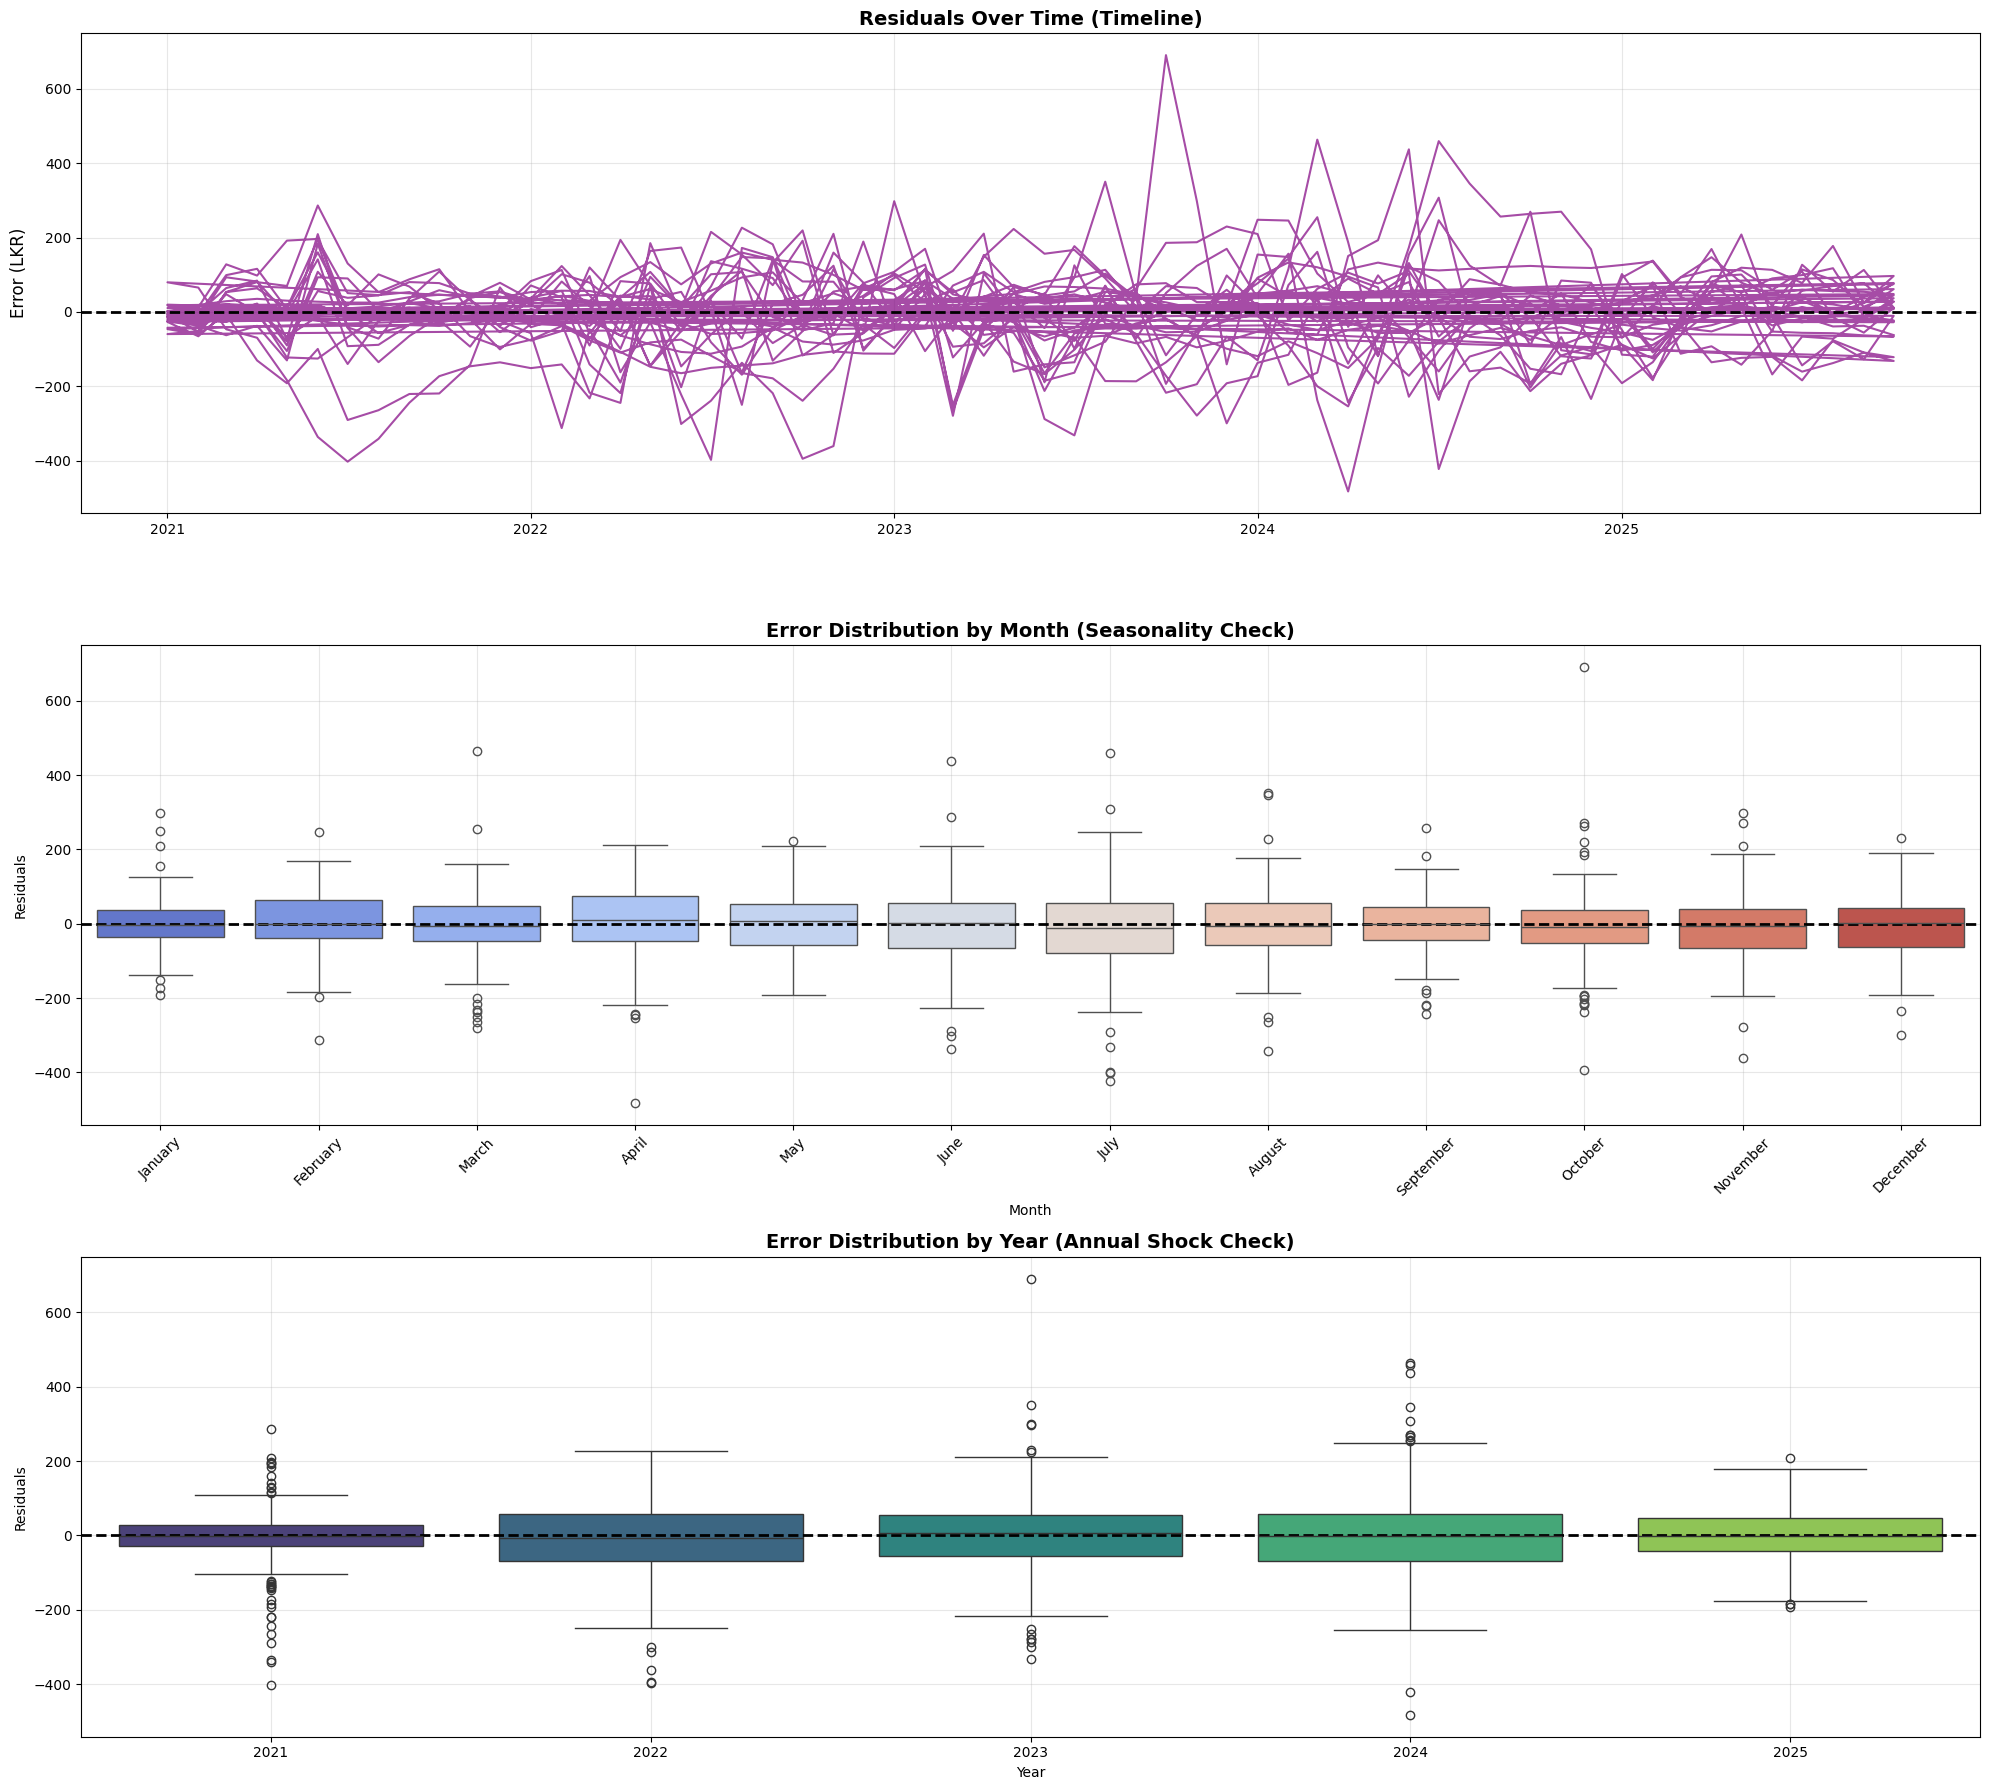


--- Residual Analysis Report ---
Mean Residual (Bias): -3.72
Standard Deviation of Error: 103.79

Months with Highest Average Error (Absolute):
Month
July        16.543935
November    10.800446
December    10.188623
Name: Residuals, dtype: float64


In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def analyze_residuals_over_time(model, df, scaler_features, scaler_target, sequence_length):
    """
    Plots residuals over time, by month, and by year to identify patterns.
    """
    print("Generating predictions for residual analysis...")
    
    # 1. Prepare sequences for the entire dataset to see the full picture
    X, y, metadata = prepare_sequences(df, sequence_length)
    
    # 2. Scale inputs
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    X_scaled = scaler_features.transform(X_reshaped).reshape(n_samples, n_timesteps, n_features)
    
    # 3. Predict
    y_pred_scaled = model.predict(X_scaled, verbose=0)
    
    # 4. Inverse transform to get actual prices
    y_pred = scaler_target.inverse_transform(y_pred_scaled).flatten()
    y_true = y.flatten() # y is already unscaled in prepare_sequences return if I recall, but let's verify. 
    # Wait, standard practice in your nb was y is unscaled in prepare_sequences output? 
    # Let's assume y from prepare_sequences is raw. If it was scaled outside, we'd invert it.
    # Looking at your train_model function, y comes raw from prepare_sequences.
    
    # Calculate Residuals
    residuals = y_true - y_pred
    
    # 5. Create Analysis DataFrame
    # Extract dates from metadata
    dates = [meta['date'] for meta in metadata]
    
    res_df = pd.DataFrame({
        'Date': pd.to_datetime(dates),
        'Actual': y_true,
        'Predicted': y_pred,
        'Residuals': residuals
    })
    
    res_df['Year'] = res_df['Date'].dt.year
    res_df['Month'] = res_df['Date'].dt.month_name()
    # Sort months correctly
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    # --- PLOTTING ---
    fig = plt.figure(figsize=(20, 18))
    
    # Plot 1: Residuals Over Time (Time Series)
    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(res_df['Date'], res_df['Residuals'], color='purple', alpha=0.7)
    ax1.axhline(0, color='black', linestyle='--', linewidth=2)
    ax1.set_title('Residuals Over Time (Timeline)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Error (LKR)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Residuals by Month (Seasonality Check)
    ax2 = plt.subplot(3, 1, 2)
    sns.boxplot(x='Month', y='Residuals', data=res_df, order=month_order, palette='coolwarm', ax=ax2)
    ax2.axhline(0, color='black', linestyle='--', linewidth=2)
    ax2.set_title('Error Distribution by Month (Seasonality Check)', fontsize=14, fontweight='bold')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Residuals by Year (Trend/Shock Check)
    ax3 = plt.subplot(3, 1, 3)
    sns.boxplot(x='Year', y='Residuals', data=res_df, palette='viridis', ax=ax3)
    ax3.axhline(0, color='black', linestyle='--', linewidth=2)
    ax3.set_title('Error Distribution by Year (Annual Shock Check)', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # --- STATISTICS ---
    print("\n--- Residual Analysis Report ---")
    print(f"Mean Residual (Bias): {residuals.mean():.2f}")
    print(f"Standard Deviation of Error: {residuals.std():.2f}")
    print("\nMonths with Highest Average Error (Absolute):")
    monthly_error = res_df.groupby('Month')['Residuals'].mean().abs().sort_values(ascending=False)
    print(monthly_error.head(3))

# Run the analysis
analyze_residuals_over_time(model, df, scaler_features, scaler_target, SEQUENCE_LENGTH)